In [1]:
%matplotlib inline

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import math
import random
import seaborn as sns

sns.set(style="darkgrid")

## Problem 1

In this problem we will explore the effects of correlations between data points on weighted averaging. Let’s assume we have four measurements of the cross-section for the production of top quarks at the Fermilab Tevatron collider in four different decay channels, each involving a single electron or a muon and 3 or 4 jets. (Don’t worry if this is all gibberish to you - the important thing is that we have four measurements, supposedly of the same true quantity.)

$$p\overline{p}X \rightarrow \frac{e}{\mu}+ \frac{3}{4} \text{ jets}$$

For each measurement, there are four potential sources of uncertainty, as shown below:

| Channel       | Measured| Stat  | e-ID  | μ-ID  | Lumi |
|---------------|---------|-------|-------|-------|------|
| e + 3-jets    | 7.91    | 0.99  | 0.24  |   -   | 0.59 |
| e + 4-jets    | 6.82    | 0.76  | 0.18  |   -   | 0.45 |
| μ + 3-jets    | 7.69    | 1.06  |   -   | 0.40  | 0.63 |
| μ + 4-jets    | 9.00    | 0.98  |   -   | 0.37  | 0.59 |

where

**Meas**: the measured cross-section in pico-barns

**Stat**: the statistical and other uncorrelated errors on the measurement
* uncorrelated for all measurements

**e/μ-ID**: the  uncertainty  due  to  estimating  the  efficiency  for  identifying  electrons  (e)  or muons (μ)
* the e-ID uncertainties are +100% correlated between the e +n-jets channels
* the μ-ID uncertainties are +100% correlated between the μ +n-jets channels

**Lumi**: the uncertainty due to estimating the luminosity used in the measurement
* +100% correlated for all measurements  
    
Your job is to write code to calculate the weighted average of these measurements, taking into account the correlations. Use this code to answer the following questions.

In [2]:
measurements = np.array([ 7.91, 6.82, 7.69, 9.00 ])

errors = np.array([[0.99, 0.24, 0, 0.59], 
                   [0.76, 0.18, 0, 0.45], 
                   [1.06, 0, 0.40, 0.63], 
                   [0.98, 0, 0.37, 0.59]])

### a) 
What is the weighted average and uncertainty of the measurements if correlations are ignored?

In [3]:
def pyWgtAve(data, sigma):
    '''
     pyWgtAve: Uncorrelated measurements version
        <X>     = [Sum X_i / sigma_i^2] err^2
        1/err^2 = Sum 1/sigma_i^2
     Derived from cpWgtAve() in cpStatistics.cpp given by H. Evans.
    '''
    N = len(data)  
    assert(len(sigma) == N)  # both data & sigma should have the same dimension

    ## # of Degrees of Freedom = N_meas - 1
    ## one d.o.f. is used to create average from data points themselves
    Ndof = N - 1

    ## Accumulate sums for <X> and sigma
    Xave = 0.0
    err = 0.0
    for i in range(N):
        den = sigma[i] * sigma[i]
        Xave += data[i] / den      # X_i / sigma_i^2
        err  += 1.0 / den          # 1 / sigma_i^2
    Xave = Xave / err              # average gets weigthed by Sum (1/sigma_i^2)
    err = math.sqrt(1.0 / err)     # error

    ## Now calculate the chi^2 between data and average
    chi2 = 0.0
    for i in range(N):
        chi2 += (data[i] - Xave) * (data[i] - Xave) / (sigma[i] * sigma[i])

    return (Xave, err, chi2, Ndof)

Xave, err, chi2, Ndof = pyWgtAve(measurements, sum(np.transpose(errors)))

print(" The weighted average is {},\n with an error of {},\n a Chi squared of {},\n and {} degrees of freedom.".format(Xave, err, chi2, Ndof))

 The weighted average is 7.662757723701624,
 with an error of 0.8723390155914105,
 a Chi squared of 0.8613594253340597,
 and 3 degrees of freedom.


### b)
What is the covariance matrix for the measurements including the correlations described above?

Stat Covariance matrix
$$\begin{pmatrix} 
\sigma_{S1}^2 & 0 & 0 & 0\\
0 & \sigma_{S2}^2 & 0 & 0\\
0 & 0 & \sigma_{S3}^2 & 0\\
0 & 0 & 0 & \sigma_{S4}^2\\
\end{pmatrix} = V_{Stat}
$$

Electron-ID Covariance matrix
$$\begin{pmatrix} 
\sigma_{e3}^2 & P_{34}\sigma_{e3}\sigma_{e4} & 0 & 0\\
P_{34}\sigma_{e3}\sigma_{e4} & \sigma_{e4}^2 & 0 & 0\\
0 & 0 & 0 & 0\\
0 & 0 & 0 & 0\\
\end{pmatrix} = V_{e-ID}
$$

Muon-ID Covariance matrix
$$\begin{pmatrix} 
0 & 0 & 0 & 0\\
0 & 0 & 0 & 0\\
0 & 0 & \sigma_{\mu3}^2 &  P_{34}\sigma_{\mu3}\sigma_{\mu4}\\
0 & 0 & P_{34}\sigma_{\mu3}\sigma_{\mu4} & \sigma_{\mu4}^2\\
\end{pmatrix} = V_{\mu-ID}
$$

Lumi Covariance matrix
$$\begin{pmatrix} 
\sigma_{1}^2 & P_{12}\sigma_{1}\sigma_{2} & P_{13}\sigma_{1}\sigma_{3} & P_{14}\sigma_{1}\sigma_{4}\\
P_{12}\sigma_{1}\sigma_{2} & \sigma_{2}^2 & P_{23}\sigma_{2}\sigma_{3} & P_{24}\sigma_{2}\sigma_{4}\\
P_{13}\sigma_{1}\sigma_{3} & P_{23}\sigma_{2}\sigma_{3} & \sigma_{3}^2 & P_{34}\sigma_{3}\sigma_{4}\\
P_{14}\sigma_{1}\sigma_{4} & P_{24}\sigma_{2}\sigma_{4} & P_{34}\sigma_{3}\sigma_{4} & \sigma_{4}^2\\
\end{pmatrix} = V_{Lumi}
$$

$$ V= V_{stat} + V_{e-ID} + V_{\mu-ID} + V_{Lumi}$$

In [4]:
# P is 1 because the errors are 100% correlated

V_stat = np.array([[0.99 * 0.99, 0, 0, 0],
                   [0, 0.76 * 0.76, 0, 0], 
                   [0, 0, 1.06 * 1.06, 0], 
                   [0, 0, 0, 0.98 * 0.98]])

V_eID = np.array([[0.24 * 0.24, 0.24 * 0.18, 0, 0], 
                  [0.24 * 0.18, 0.18 * 0.18, 0, 0],
                  [          0,           0, 0, 0],
                  [          0,           0, 0, 0]])

V_μID = np.array([[0, 0,           0,           0],
                  [0, 0,           0,           0],
                  [0, 0, 0.40 * 0.40, 0.40 * 0.37],
                  [0, 0, 0.40 * 0.37, 0.37 * 0.37]])

V_lumi = np.array([[0.59 * 0.59, 0.59 * 0.45, 0.59 * 0.63, 0.59 * 0.59],
                   [0.59 * 0.45, 0.45 * 0.45, 0.45 * 0.63, 0.45 * 0.59],
                   [0.59 * 0.63, 0.45 * 0.63, 0.63 * 0.63, 0.63 * 0.59], 
                   [0.59 * 0.59, 0.45 * 0.59, 0.63 * 0.59, 0.59 * 0.59]])

V = V_stat + V_eID + V_μID + V_lumi

print(V)

[[1.3858 0.3087 0.3717 0.3481]
 [0.3087 0.8125 0.2835 0.2655]
 [0.3717 0.2835 1.6805 0.5197]
 [0.3481 0.2655 0.5197 1.4454]]


### c)
Using that covariance matrix, calculate the weighted average and uncertainty of the measurements taking correlations properly into account.

In [5]:
def pyWgtAveCov(data, cov):
    N = len(data)  
    invcov = np.linalg.inv(cov)

    ## # of Degrees of Freedom = N_meas - 1
    ## one d.o.f. is used to create average from data points themselves
    Ndof = N - 1

    ## Accumulate sums for <X> and sigma
    Xave = 0.0       
    err = 0.0
    for i in range(N):
        for j in range(N):
            Xave += invcov[i][j] * (data[i] + data[j])  
            err += invcov[i][j]          
    Xave = Xave / (2.0 * err)      
    err = math.sqrt(1.0 / err)
                 
    chi2 = 0.0
    for i in range(N):
        for j in range(N):
            chi2 += (data[i] - Xave) * invcov[i][j] * (data[j] - Xave)

    return (Xave, err, chi2, Ndof)

Xave_2, err_2, chi2_2, Ndof_2 = pyWgtAveCov(measurements, V)

print(" The weighted average is {},\n with an error of {},\n a Chi squared of {},\n and {} degrees of freedom.".format(Xave_2, err_2, chi2_2, Ndof_2))

 The weighted average is 7.563293506958378,
 with an error of 0.7332499405279995,
 a Chi squared of 2.8676106382803557,
 and 3 degrees of freedom.


### d)
What is the χ2 and χ2 probability for uncorrelated and correlated averages? Are these results likely to be consistent?

In [6]:
print(" The Chi Squared for the uncorrelated average is {}, with {} degrees of freedom".format(chi2, Ndof))
print(" The p-value for the the uncorrelated average is .834756")
print(" The Chi Squared for the correlated average is {}, with {} degrees of freedom.".format(chi2_2, Ndof_2))
print(" The p-value for the correlated average is .412492")

 The Chi Squared for the uncorrelated average is 0.8613594253340597, with 3 degrees of freedom
 The p-value for the the uncorrelated average is .834756
 The Chi Squared for the correlated average is 2.8676106382803557, with 3 degrees of freedom.
 The p-value for the correlated average is .412492


The chi squared and p-value when correlations are ignored imply that your model for the data is fairly good, where as when you add in the correlations both the value for the chi squared and the probalility decrease, which makes sense since when we ignore the correlations between data, it makes it seem better than it truely is, and the correlated chi squared and probalility show this. 

## Problem 2

In this problem we will explore the effects of non-Gaussian errors on the relationship between confidence regions and the fit covariance matrix. Use the example we did in class of data drawn from a linear model with:

$$ x \in [0,1]$$
$$f(x) = ax+b \text{  (measurements, y, drawn from this model)}$$
$$a = 1$$
$$b=0.5$$
$$N=10 \text{ measurments / experiment}$$
$$M=1001 \text{  experiments}$$

But, for this problem, assume that the measurements, yi, take values that are uniformly (rather than normally) distributed about their true values, f(x) =a+bx. Use:

$$ y_i -f(x_i)\in[-0.15, +0.15] \text{  (uniformly)}$$

Please do the following:

### a)
Simulate one experiment using the parameters above (with yi drawn uniformly from the region[−0.15,+0.15]about the true value f(xi).  Make a plot of yi vs xi, including errors on yi from the standard deviation of a uniform distribution(width/√12).

In [7]:
def experiment(min_dy, max_dy, N = 10):
    '''
     @param min_dy: minimum delta to apply to generated y value
     @param max_dy: maximum delta to apply to generated y value
     @param N:  measurements per experiment (defaults to 10)
    '''
    x = []
    y = []
    fx = []
    err = []
    for i in range(N):
        xi = random.random()
        fxi = 1.0 + .5 * xi
        yi = fxi + ((random.random() * (max_dy - min_dy)) + min_dy)
        erri = yi - fxi
        x.append(xi)
        fx.append(fxi)
        y.append(yi)
        err.append(erri)
    return (x, y, fx, err)

min_dy = -.15
max_dy = .15
sd = (max_dy - min_dy) / math.sqrt(12.0)

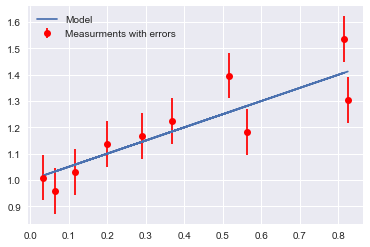

In [8]:
x, y, fx, err = experiment(min_dy, max_dy)
plt.plot(x, fx, label='Model')
plt.errorbar(x, y, yerr=sd, fmt='ro', label='Measurments with errors')
plt.legend()
plt.show()

### b)
Now perform a χ2 fit to the data that you produced in part a.  Simultaneously extract best-fit values for a, b, and their covariance matrix.  In your χ2, use errors on the yi’s as in part a. (0.3/√12) as is often assumed in these situations. What are the parameter values and covariance matrix that your fit returns and what is the χ2 and probability of the fit?  Do your fit results agree with the values input to your simulation?

In [9]:
def pyChi2(meas, pred, sig, Nconstr):
    ''' Based on cpChi2() (least squares version) in cpStatistics.cpp given by H. Evans. '''
    ## number of bins and initial value of N degrees of freedom
    N = len(meas)
    assert(len(pred) == N)
    assert(len(sig) == N)
    Ndof = N - Nconstr
    ## loop over bins, accumulate sums
    chi2 = 0.0
    for i in range(N):
        ## don't count bins with sigma = 0 (this is an approximation)
        if (sig[i] == 0.0):
            Ndof -= 1
        ## non-zero data and prediction, add to sum
        else:
            chi2 += (meas[i] - pred[i]) * (meas[i] - pred[i]) / (sig[i] * sig[i])
    return (chi2, Ndof)

In [10]:
def pyLinReg(x, y, sig):
    ''' Based on cpLinReg() in cpStatistics.cpp given by H. Evans. '''
    N = len(x)
    assert(len(y) == N)

    ## Accumulate Sums
    S = 0.0
    Sx = 0.0
    Sy = 0.0
    for i in range(N):
        w = 1.0 / (sig[i] * sig[i])
        S += w
        Sx += x[i] * w
        Sy += y[i] * w
    SxoS = Sx / S
    Stt = 0.0
    b = 0.0
    for i in range(N):
        t = (x[i] - SxoS) / sig[i]
        Stt += t * t
        b += t * y[i] / sig[i]

    ## Best fit parameters
    b = b / Stt
    a = (Sy - Sx * b) / S

    ## covariance matrix
    V00 = (1.0 + Sx * Sx / (S * Stt)) / S
    V01 = -Sx / (S * Stt)
    V11 = 1.0 / Stt
    V = np.array([ [V00, V01], [V01, V11] ])

    ## Calculate chi^2
    f = []
    for i in range(N):
        f.append(a + b * x[i])
    (chi2, Ndof) = pyChi2(y, f, sig, 2)      # chi^2 w/ 2 constraints

    return (a, b, V, chi2, Ndof)

 a is 0.9882795502853047,
 b is 0.5429468328317545,
 with a covariance matrix of: 
[[ 0.00215716 -0.00371107]
 [-0.00371107  0.00978711]],
 a Chi Squared of 8.78709125302064,
 and 8 degrees of freedom,
 and a Chi Squared Probability of 0.6394260396987121.


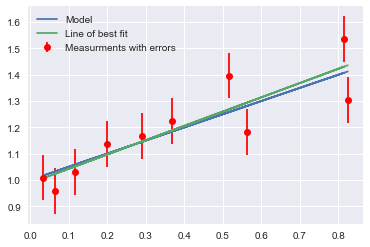

In [11]:
a, b, V, chi2, Ndof = pyLinReg(x, y, [sd] * len(y))
Pchi2 = stats.chi2.cdf(chi2, Ndof)
print(" a is {},\n b is {},\n with a covariance matrix of: \n{},\n a Chi Squared of {},\n and {} degrees of freedom,\n and a Chi Squared Probability of {}.".format(a, b, V, chi2, Ndof, Pchi2)) 
plt.plot(x, fx, label="Model")
plt.plot(x, [(a + b * xi) for xi in x], label='Line of best fit')
plt.errorbar(x, y, yerr=sd, fmt='ro', label='Measurments with errors')
plt.legend()
plt.show()

Given this Chi square and probablility, the results agree with the model of y=x+0.5, but since the measurements are random, this is not always the case. This set of results agrees with the model particularly well.

In [12]:
a_values = []
b_values = []
for i in range(1001):
    x_new, y_new, fx, err = experiment(min_dy, max_dy)
    a_new, b_new, V_new, chi2_new, Ndof_new = pyLinReg(x_new, y_new, [sd] * len(y))
    a_values.append(a_new)
    b_values.append(b_new)

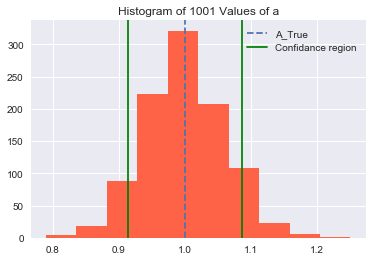

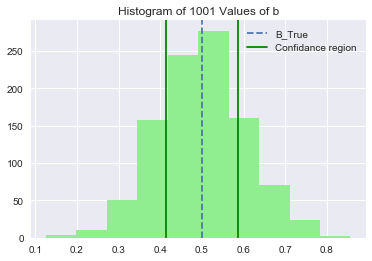

In [13]:
plt.hist(a_values, color="tomato")
plt.axvline(1, linestyle="--", label='A_True')
plt.axvline(1 + 0.3/(math.sqrt(12)), color='g', label='Confidance region')
plt.axvline(1 - 0.3/(math.sqrt(12)), color='g')
plt.title("Histogram of 1001 Values of a")
plt.legend()
plt.show()
plt.hist(b_values, color="lightgreen")
plt.axvline(0.5, linestyle="--", label='B_True')
plt.axvline(0.5 + 0.3/(math.sqrt(12)), color='g', label='Confidance region')
plt.axvline(0.5 - 0.3/(math.sqrt(12)), color='g')
plt.title("Histogram of 1001 Values of b")
plt.legend()
plt.show()

For the a values, they are centered around the true value of 1, with roughly 70% of the values falling within the confidance region. For the b values, they are also centered around the true value of 0.5, with roughly 55% of the values falling within the confidance region.

### d)
Repeat the fits to your 1,000 experiments using σi= 0.15. (This is another common way of dealing with uniform uncertainty regions.)  What fraction of fits fall within the Gaussian 68.3% confidence region in this case?

In [14]:
sd_new = 0.15

a_values = []
b_values = []
for i in range(1001):
    x_new, y_new, fx, err = experiment(min_dy, max_dy)
    a_new, b_new, V_new, chi2_new, Ndof_new = pyLinReg(x_new, y_new, [sd_new] * len(y))
    a_values.append(a_new)
    b_values.append(b_new)

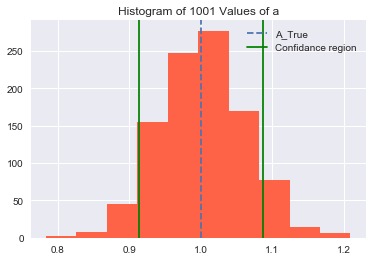

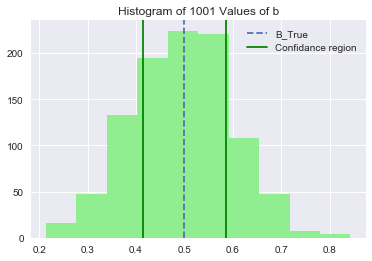

In [15]:
plt.hist(a_values, color="tomato")
plt.axvline(1, linestyle="--", label='A_True')
plt.axvline(1 + 0.3/(math.sqrt(12)), color='g', label='Confidance region')
plt.axvline(1 - 0.3/(math.sqrt(12)), color='g')
plt.title("Histogram of 1001 Values of a")
plt.legend()
plt.show()
plt.hist(b_values, color="lightgreen")
plt.axvline(0.5, linestyle="--", label='B_True')
plt.axvline(0.5 + 0.3/(math.sqrt(12)), color='g', label='Confidance region')
plt.axvline(0.5 - 0.3/(math.sqrt(12)), color='g')
plt.title("Histogram of 1001 Values of b")
plt.legend()
plt.show()

For this σ, a larger number of the fits fall within this confidence region.